##  Question A

In [1]:
# Importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import os
import librosa
# import sounddevice as sd # Can be commented out if it's not installed on your system, it's not necessary for the code to run
from scipy.io import wavfile
from scipy.signal import find_peaks
from scipy.interpolate import interp1d


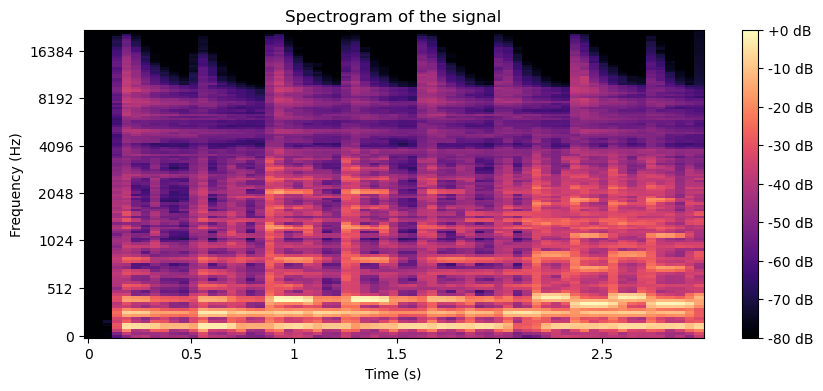

The 10 strongest frequencies extracted from the signal are:
1. 2122.84 Hz
2. 2035.38 Hz
3. 2144.04 Hz
4. 2056.59 Hz
5. 2366.66 Hz
6. 2292.46 Hz
7. 2387.87 Hz
8. 548.60 Hz
9. 2316.31 Hz
10. 720.87 Hz


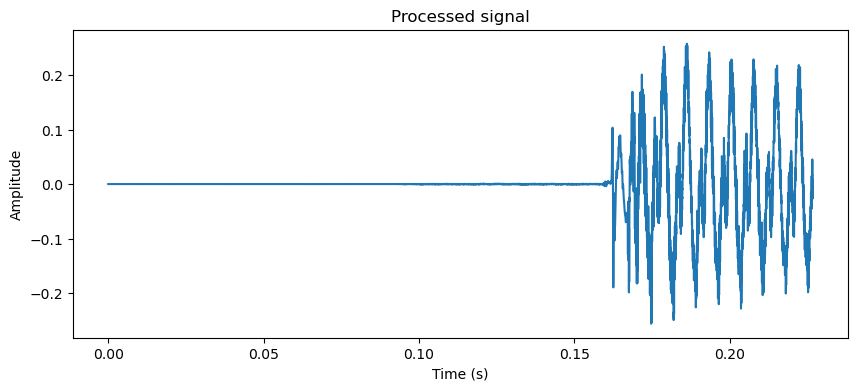

In [2]:
# Code that corresponds to Question A 

# First, we need to define a musical signal (not a noisy one) with a duration not longer than 3 seconds (and a frequency of our choosing)
# We can either load a prievously created signal or a new one (like a song)

# We will load it using the librosa library (equivalent to MATLAB's audioread function)
wav_file = 'Vasileios_Katsaitis_Assignment_1_8_seconds.wav'
sr = 44100 # sampling rate
duration = 3 # seconds
max_duration = 3 # seconds
N = sr * duration # number of samples
t = np.linspace(0, duration, N, endpoint = False) # time vector
signal_A, new_sr = librosa.load(wav_file, sr = sr, mono = False) # This method automatically normalizes the signal
# NOTE: For mono signals, we can use the argument mono = False in function above to load the audio signal as stereo (in order to create 2 channels and test our code)

# We, now, check if the signal is in stereo
# Essentially, signal is a 1D array if it's mono and a 2D array if it's stereo
if signal_A.ndim == 2: # If the signal is in stereo
    # We initially compute the RMS value for each channel
    rms_values = [librosa.feature.rms(y = channel) for channel in signal_A] # rms_values is a list of two 1D arrays containing the RMS values of each channel
    
    # We, now, select the channel with the highest RMS value
    # We do this by first creating a list of the maximum RMS values of each channel and then selecting the index of the highest value (channel index)
    max_RMS_values = [np.max(rms) for rms in rms_values]
    highest_RMS_channel_index = np.argmax(max_RMS_values)
        
    # And we keep only the selected channel, discarding the other one
    signal_A = signal_A[highest_RMS_channel_index]


# We trim the signal to 3 seconds if it exceeds that duration
if len(signal_A) > max_duration * new_sr:
    signal_A = signal_A[:max_duration * new_sr] # Remember that max_duration * new_sr = number of samples of loaded signal
    
# We remove the DC component (mean value of the signal)
signal_A = signal_A - np.mean(signal_A)

# Plotting the signal's spectrogram using a Hanning window of length 4096 samples and 50% overlap (hop size)
# First, we define our hyperparameters
n_fft = 4096  # FFT length
hop_length = int(n_fft / 2)  # Hop size (50% overlap)

# We, now, compute the spectrogram using the librosa library
spectrogram = librosa.feature.melspectrogram(y = signal_A, sr = new_sr, n_fft = n_fft, hop_length = hop_length, window = 'hann')

# We convert the power spectrogram to dB
spectrogram_db = librosa.power_to_db(spectrogram, ref = np.max)

# We, now, plot the spectrogram
plt.figure(figsize = (10, 4))
librosa.display.specshow(spectrogram_db, sr = new_sr, hop_length = hop_length, x_axis = 'time', y_axis = 'mel')
plt.colorbar(format = '%+2.0f dB')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Spectrogram of the signal')
plt.show()


# Extracting the 10 strongest frequencies (peaks) from the signal (using the spectrogram)
# We first define the number of peaks we want to extract (hyperparameter)
n_peaks = 10

# We want to find the peaks of the spectrogram
# We will use the find_peaks function from the scipy library
# We need to flatten the spectrogram first, in order to find the peaks
spectrogram_db_flat = spectrogram_db.flatten()
peaks, _ = find_peaks(spectrogram_db_flat, distance = 1) # We set the distance between peaks to 1 in order to find all peaks

# We, now, sort the peaks in descending order of their values
sorted_peaks = np.argsort(spectrogram_db_flat[peaks])[::-1] # We use argsort to get the indices of the sorted peaks and then reverse the order

# We, also, want to extract the magnitude of the peaks
peak_magnitudes = spectrogram_db_flat[peaks]

# We, now, extract the frequencies of the 'n_peaks' (10) strongest peaks 
strongest_frequencies = []
for peak in sorted_peaks[:n_peaks]:
    # We first compute the index of the peak in the spectrogram
    peak_index = peaks[peak]
    
    # We, now, get the frequency of the peak as such:
    # We scale the peak index to the range of frequencies (0 to sr / 2), using the formula below.
    # We divide by len(spectrogram_db_flat), because we want to scale frequency and get it to fall into the range of [0, new_sr / 2], since that is the range of frequencies of the spectrogram
    frequency = peak_index * (new_sr / 2) / len(spectrogram_db_flat)
    strongest_frequencies.append(frequency)

# We, now, print the extracted frequencies
print('The 10 strongest frequencies extracted from the signal are:')
for i in range(len(strongest_frequencies)):
    print(f'{i + 1}. {strongest_frequencies[i]:.2f} Hz')

# We play the signal
# sd.play(signal_A, new_sr)

# We quantize the signal using 32-bit PCM
# signal_A = np.int32(signal_A * (2**31 - 1)) # Commenting out this line means that signal will still be normalized, but not replayed by Windows Media Player

# Since it's not mandatory to run first two code cells, we need to create the folder 'Sound files' if it doesn't already exist
if not os.path.exists('Sound files'):
    os.makedirs('Sound files')

# We save the signal
wavfile.write('Sound files/processed_signal_A.wav', new_sr, signal_A)

# We, optionally, plot the signal
plt.figure(figsize = (10, 4))
plt.plot(t[:10000], signal_A[:10000]) # We plot only the first 10000 samples so that it's easier to visualize the signal
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Processed signal')
plt.show()


### Question C, subquestion 1 (C1)

In [3]:
# In this code cell, we will be using the sound we analyzed in question A (signal_A) to compute and display its RMS amplitude envelope,
# using a block size of 50 milliseconds without overlapping.

# Our task is to modify given function below, which returns objects 'RMS' and 't', where RMS is the RMS amplitude envelope and t is the time
# vector corresponding to the RMS values.
# NOTE: Arguments 'BlockLength' and 'HopLength' are supposed to be in samples, not seconds.
def myRMSenv(x, BlockLength, HopLength, fs):
    # We first need to compute the number of blocks and the number of samples in the signal
    NumOfBlocks = int(np.ceil(len(x) // HopLength)) # Number of blocks
    
    # We, now, compute the time stamps
    t = np.arange(0, NumOfBlocks) * HopLength + (BlockLength // 2) / fs # Time vector
    
    # We allocate appropriate memory for the RMS amplitude envelope
    RMS = np.zeros(NumOfBlocks) # RMS amplitude envelope
    
    for i in range(NumOfBlocks):
        # We compute the start and end indices of the block
        start_index = i * HopLength
        end_index = min(start_index + BlockLength, len(x))
        
        # We compute the RMS value of the block
        RMS[i] = np.sqrt(np.mean(x[start_index:end_index] ** 2)) # We use the formula for RMS value of a signal
    
    return RMS, t

### Question C, subquestion 2 (C2)

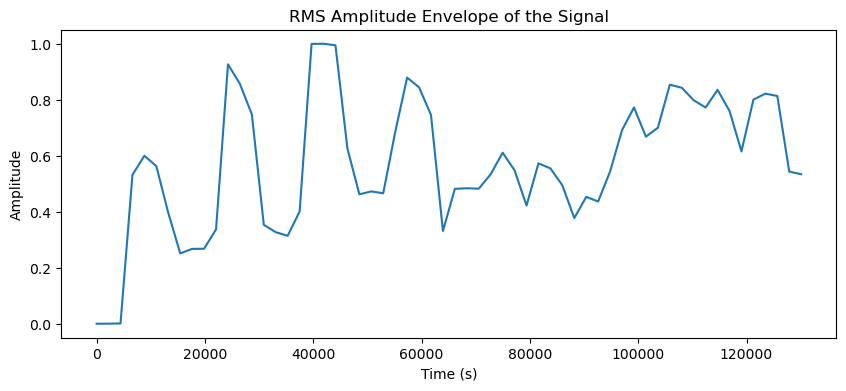

In [4]:
# In this code cell, we will interpolate the RMS amplitude envelope to have the same length as the original signal, 
# normalize its values and then plot it.

# As was previously stated, we will be using the 3 second long signal we analyzed in question A (signal_A).
# First, we define our hyperparameters:
fs_C = 44100 # Sampling rate
Ts_C = 1 / fs_C # Sampling period
t = np.arange(0, len(signal_A) / fs_C, Ts_C) # Time vector of the original signal
BlockLength = int(0.05 * fs_C) # Block length of 50 milliseconds (calculated in samples)
HopLength = BlockLength # Hop length is equal to the block length (no overlap)

# We, now, compute the RMS amplitude envelope of the signal using the given function
RMS, t_RMS = myRMSenv(signal_A, BlockLength, HopLength, fs_C)

# We, then, use linear interpolation to interpolate the RMS amplitude envelope to have the same length as the original signal
RMS_interp = interp1d(t_RMS, RMS, kind = 'linear')(t_RMS) # We use linear interpolation with the new time vector

# We normalize the interpolated RMS amplitude envelope
RMS_interp = RMS_interp / RMS_interp.max() # Scaling the values so that they reach a maximum of 1

# We, finally, plot the RMS amplitude envelope
plt.figure(figsize = (10, 4))
plt.plot(t_RMS, RMS_interp)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('RMS Amplitude Envelope of the Signal')
plt.show()


### Question C, subquestion 3 (C3)

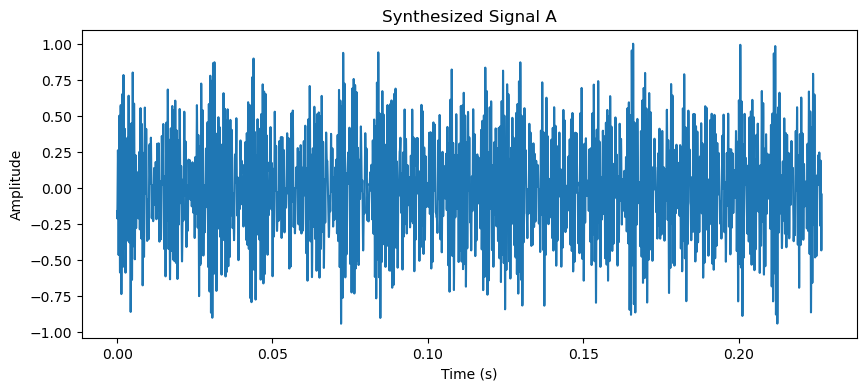

Fundamental Frequency: 548.5997596153846


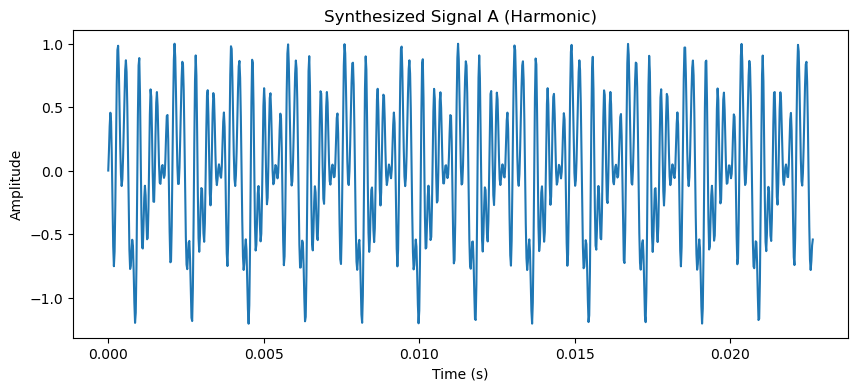

In [5]:
# In this code cell, we will create a sound using additive synthesis for the frequencies and their (possibly average) 
# magnitudes we estimated in question A, and then play the sound.
# We may experiment with different phases for each sinusoid to create different timbres and pick the phase configuration that sounds best to us.

# For that purpose, we use the same sampling rate as before (new_sr = 44100 Hz) and the same duration (duration = 3 seconds).
t = np.linspace(0, duration, int(new_sr * duration), endpoint = False) # Time vector

# We, now, want to use the magnitudes and frequencies we estimated in question A to create the sound using additive synthesis
frequencies_A = strongest_frequencies # The 10 strongest frequencies 
magnitudes_A = peak_magnitudes # Magnitudes (we can experiment with different magnitudes) 
average_magnitude = np.mean(magnitudes_A) # Average magnitude of the frequencies


#* IMPLEMENTATION 1: In this implementation, we use the 10 strongest frequencies from the spectrogram to create our synthesized sound.
#* We do NOT use any harmonic relationship between the frequencies, but simply add the sinusoidal waves corresponding to each frequency to create the sound.

# We also set random phases for each frequency to create different timbres
random_phases = np.random.uniform(0, 2 * np.pi, len(frequencies_A))

# We, now, create the sound using additive synthesis
synthesized_signal_A = np.zeros(len(t)) # Initialize the sound signal
for i, frequency in enumerate(frequencies_A):
    # We, then, create the sinusoidal wave corresponding to the frequency
    sine_wave = average_magnitude * np.cos(2 * np.pi * frequency * t + random_phases[i])
    
    # We, now, add the sine wave corresponding to each note to the signal
    synthesized_signal_A += sine_wave

# We normalize the synthesized signal
synthesized_signal_A = synthesized_signal_A / synthesized_signal_A.max()

# We, now, play the synthesized sound (although it may not sound very pleasant)
# We will use a volume factor to lower its volume, as the sound is rather loud
# volume_factor = 0.6
# sd.play(synthesized_signal_A * volume_factor, new_sr)

# We quantize the signal using 32-bit PCM (not neccessary, again can be commented out)
# synthesized_sound_A = np.int32(synthesized_sound_A * (2**31 - 1))

# We save the signal in the 'Sound files' folder
wavfile.write('Sound files/synthesized_signal_A.wav', new_sr, synthesized_signal_A)

# We, optionally, plot the synthesized sound
plt.figure(figsize = (10, 4))
plt.plot(t[:10000], synthesized_signal_A[:10000]) # We plot only the first 10000 samples so that it's easier to visualize the signal
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Synthesized Signal A')
plt.show()


# NOTE: We notice that the synthesized sound may not sound very pleasant, as the frequencies and magnitudes we estimated in question A may not correspond to a harmonic sound.
# This is because the frequencies we estimated are the strongest frequencies in the signal, which may not necessarily correspond to the fundamental frequencies of a harmonic sound.
# In order to create a more pleasant sound, we would need to estimate the fundamental frequency of the sound and then synthesize the harmonics around that frequency.

#* IMPLEMENTATION 2: Now, we will repeat the same process as the one above, using the fundamental frequency of the synthesized sound.
#* This creates a more harmonic sound, as we use the fundamental frequency and its integer multiples (as well as a random offset defined in every loop).

# First, we spot the lowest harmonic frequency
fundamental_frequency = None # We use the lowest frequency as the fundamental frequency
strongest_frequency = max(frequencies_A) # We use the highest frequency as the fundamental frequency
for freq in frequencies_A:
    if freq < strongest_frequency / 2: # We use the frequency that is less than half of the highest frequency
        fundamental_frequency = freq
        break

# We, then, check for integer multiples of the fundamental frequency
if fundamental_frequency is not None: # If a fundamental frequency is found
    print("Fundamental Frequency:", fundamental_frequency)
    for freq in frequencies_A:
        if freq % fundamental_frequency == 0: 
            fundamental_frequency = freq # We, now, use the frequency that is an integer multiple of the fundamental frequency


# We repeat the same additive synthesis process using the fundamental frequency and its harmonics
synthesized_signal_harmonic = np.zeros(len(t)) # Initialize the sound signal
for i in range(1, 11): # We use the first 10 harmonics
    # We, then, create the sinusoidal wave corresponding to the harmonic
    random_phase = np.random.uniform(0, 2 * np.pi) # Random phase for each harmonic (to create different timbres)
    sine_wave = np.cos(2 * np.pi * fundamental_frequency * i * t + random_phase) # We use the fundamental frequency and its integer multiples
    
    # We, now, add the sine wave corresponding to each harmonic to the signal
    synthesized_signal_harmonic += sine_wave
    
# We normalize the synthesized signal
synthesized_signal_harmonic = synthesized_signal_harmonic / synthesized_signal_harmonic.max()

# We, now, play the synthesized sound (which should sound more harmonic)
# We will use a volume factor to lower its volume, as the sound is rather loud
# volume_factor = 0.1
# sd.play(synthesized_signal_harmonic * volume_factor, new_sr) 

# We quantize the signal using 32-bit PCM (not neccessary, again can be commented out)
# synthesized_sound_harmonic = np.int32(synthesized_sound_harmonic * (2**31 - 1))

# We save the signal in the 'Sound files' folder
wavfile.write('Sound files/synthesized_signal_A_harmonic.wav', new_sr, synthesized_signal_harmonic)

# We, optionally, plot the synthesized sound
plt.figure(figsize = (10, 4))
plt.plot(t[:1000], synthesized_signal_harmonic[:1000]) # We plot only the first 10000 samples so that it's easier to visualize the signal
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Synthesized Signal A (Harmonic)')
plt.show()


### Question C, subquestion 4 (C4)

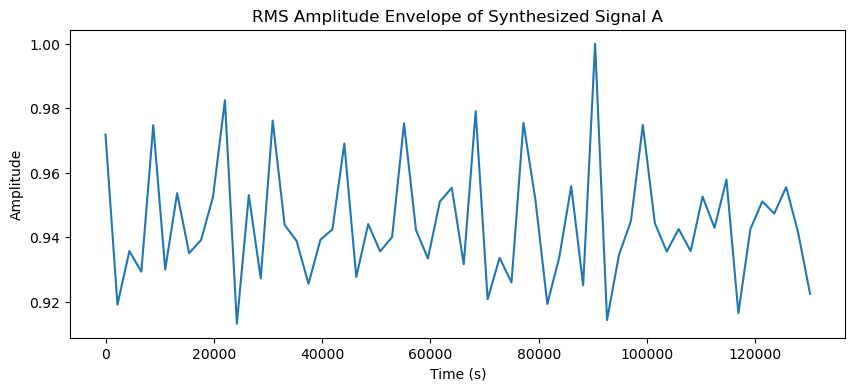

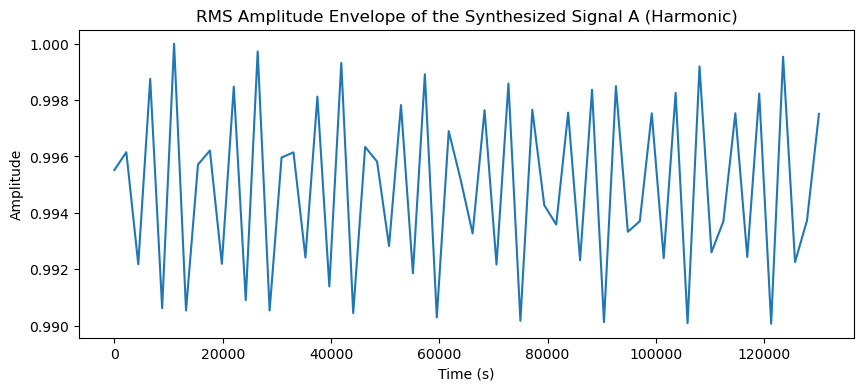

In [6]:
# In this, final, code cell, we will apply the RMS amplitude envelope we created in (C1) and used in (C2) to the synthesized sound we created in (C3).

# Applying the RMS amplitude envelope to the synthesized sound.
new_RMS_C4, new_t_RMS_C4 = myRMSenv(synthesized_signal_A, BlockLength, HopLength, fs_C) # We use the synthesized sound with the non-harmonic frequencies

# We interpolate the RMS amplitude envelope to have the same length as the original signal
new_RMS_interp_C4 = interp1d(new_t_RMS_C4, new_RMS_C4, kind = 'linear')(new_t_RMS_C4) # We use linear interpolation with the new time vector

# We normalize the interpolated RMS amplitude envelope
new_RMS_interp_C4 = new_RMS_interp_C4 / new_RMS_interp_C4.max() # Scaling the values so that they reach a maximum of 1

# And we finally plot the RMS amplitude envelope
plt.figure(figsize = (10, 4))
plt.plot(new_t_RMS_C4, new_RMS_interp_C4)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('RMS Amplitude Envelope of Synthesized Signal A')
plt.show()


# Repeating process for the synthesized sound with the harmonic frequencies 
RMS_C4, t_RMS_C4 = myRMSenv(synthesized_signal_harmonic, BlockLength, HopLength, fs_C) # We use the synthesized sound with the harmonic frequencies

# We interpolate the RMS amplitude envelope to have the same length as the original signal
RMS_interp_C4 = interp1d(t_RMS_C4, RMS_C4, kind = 'linear')(t_RMS_C4) # We use linear interpolation with the new time vector

# We normalize the interpolated RMS amplitude envelope
RMS_interp_C4 = RMS_interp_C4 / RMS_interp_C4.max() # Scaling the values so that they reach a maximum of 1

# And we finally plot the RMS amplitude envelope
plt.figure(figsize = (10, 4))
plt.plot(t_RMS_C4, RMS_interp_C4)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('RMS Amplitude Envelope of the Synthesized Signal A (Harmonic)')
plt.show()
